<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [2]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

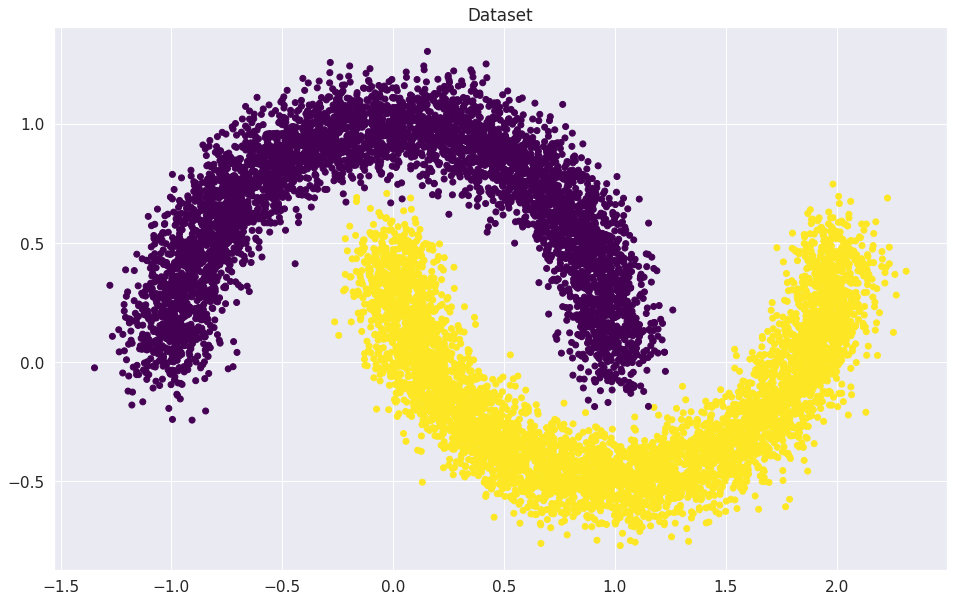

In [3]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [5]:
X_train_t = torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train) # YOUR CODE GOES HERE
X_val_t =  torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val) # YOUR CODE GOES HERE

In [6]:
X_train_t.dtype # проверка типа

torch.float32

Создаем `Dataset` и `DataLoader`. 

In [7]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [8]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn((out_features,in_features)))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features)) # YOUR CODE GOES HERE

    def forward(self, x):
        x =  x @ self.weights.T # YOUR CODE GOES HERE
        if self.bias:
            x += self.bias_term # YOUR CODE GOES HERE
        return x

In [9]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

Проверю как работает наш класс linear_regression

In [10]:
input = torch.FloatTensor([1,1])

In [11]:
input

tensor([1., 1.])

In [12]:
linear_regression.weights

Parameter containing:
tensor([[-0.1071,  0.6818]], requires_grad=True)

In [13]:
linear_regression.bias_term

Parameter containing:
tensor([-0.5583], requires_grad=True)

In [14]:
linear_regression(input)

tensor([0.0165], grad_fn=<AddBackward0>)

Проверю у аналогичного класса nn.linear

In [15]:
m = nn.Linear(2,1)
output = m(input)

In [16]:
m.weight

Parameter containing:
tensor([[0.5409, 0.3374]], requires_grad=True)

In [17]:
m.bias

Parameter containing:
tensor([-0.5215], requires_grad=True)

In [18]:
output

tensor([0.3568], grad_fn=<AddBackward0>)

In [19]:
input @ m.weight.T + m.bias # формула внутри этой функции

tensor([0.3568], grad_fn=<AddBackward0>)

In [20]:
assert input @ m.weight.T + m.bias == output # значения рукописной функции и дефолтной сошлись

Значит наш класс написан верно

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [21]:
#YOUR CODE
for i,a in enumerate(linear_regression.parameters()):
  print(i, a)

0 Parameter containing:
tensor([[-0.1071,  0.6818]], requires_grad=True)
1 Parameter containing:
tensor([-0.5583], requires_grad=True)


 2 параметра W и b - обучаемые тензоры
 
 2 числа на вход это веса + 1 число это смещение = 3 числа

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [22]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
# prev_weights = torch.zeros_like(linear_regression.weight) # for Linear(), тестил
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        
        # обнуление градиента
        optimizer.zero_grad()

        # логиты
        outp = linear_regression(X_batch).flatten() # YOUR CODE. Use linear_regression to get outputs
        # print(outp)

        # лосс
        loss = loss_function(outp, y_batch) # YOUR CODE. Compute loss
        # print(loss)

        # вычисл градиенты
        loss.backward()
        losses.append(loss.detach().flatten()[0])

        # шаг град спуска
        optimizer.step()

        probabilities =  1 / (1 + torch.exp(-outp)) # YOUR CODE. Compute probabilities
        # print(probabilities)

        # если вер-ть > 0.5 то принадлежит к 1му классу, если меньше то к 0, потом True/False  преобр в 1/0
        preds = (probabilities > 0.5).type(torch.long)

        # точность батча
        # сравниваем ответы предсказанные с реальными, получ True/False преобр в 1/0 и считаем сумму верно предск и делим на размер батча
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.3125
Iteration: 100
Batch accuracy: 0.734375
Iteration: 200
Batch accuracy: 0.78125
Iteration: 300
Batch accuracy: 0.8515625
Iteration: 400
Batch accuracy: 0.84375
Iteration: 500
Batch accuracy: 0.875
Iteration: 600
Batch accuracy: 0.859375
Iteration: 700
Batch accuracy: 0.8046875
Iteration: 800
Batch accuracy: 0.828125

Iteration: 873.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 873

### Визуализируем результаты

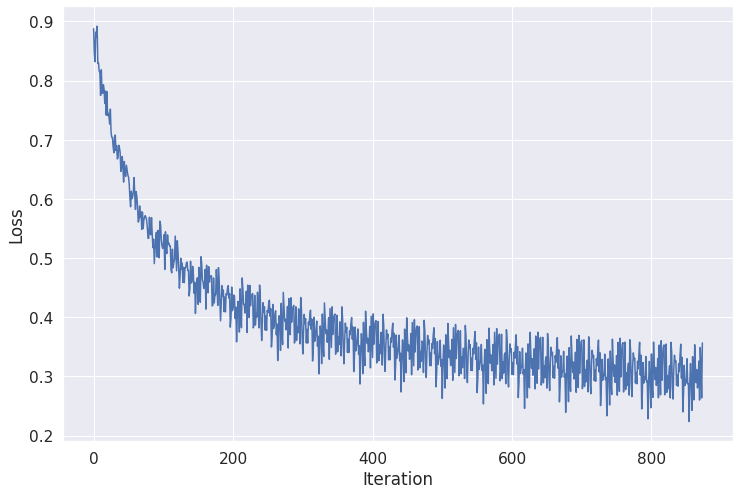

In [23]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

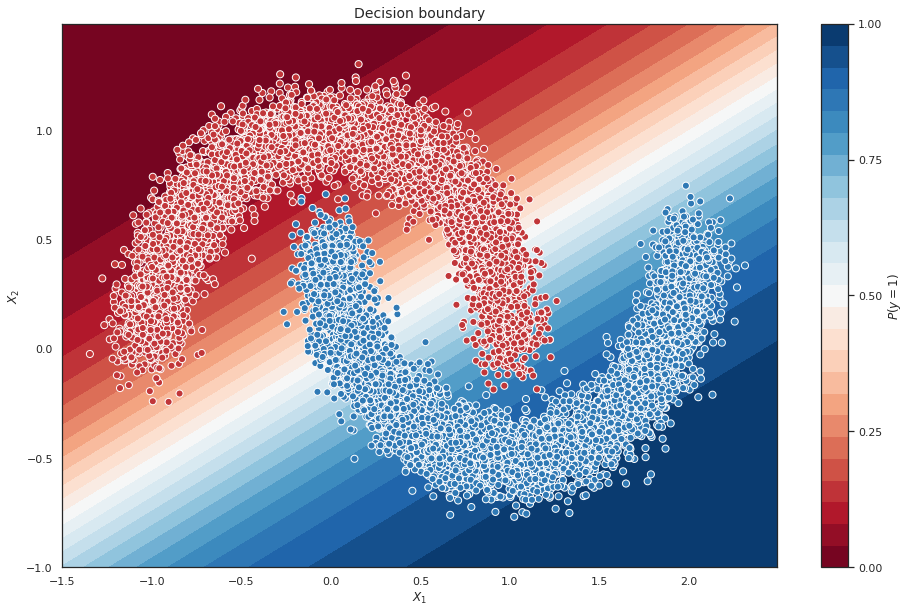

In [24]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [25]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        #<YOUR CODE>
        outp = model(x_batch).flatten()
        probabilities =  1 / (1 + torch.exp(-outp))
        preds = (probabilities > 0.5).type(torch.long) #YOUR CODE. Compute predictions
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [26]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_test_final = predict(val_dataloader,linear_regression)
y_test_final

array([1., 1., 0., ..., 1., 0., 0.])

In [27]:
accuracy_score(y_val_t, y_test_final)

0.8604

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.8604

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [28]:
import os
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader =  DataLoader(train_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size=batch_size, drop_last=True)# YOUR CODE GOES HERE

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [29]:
x_batch, y_batch = next(iter(train_dataloader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [30]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [42]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    #YOUR CODE. Add layers to your sequential class
    # 1 скрытый слой
    nn.Linear(784, 128),
    activation(),
    # 2 скрытый слой
    nn.Linear(128, 128),
    activation(),
    # выходной слой
    nn.Linear(128, 10)
)

# перенос на ГПУ при возможности
model.to(device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): ELU(alpha=1.0)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ELU(alpha=1.0)
  (5): Linear(in_features=128, out_features=10, bias=True)
)

In [43]:
criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [45]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:

            # загружаем батч данных (вытянутый в линию)
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)

            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!

                #0. перевод в тренировочный режим нашей модели
                model.train()

                # 0.1 Обнуление градиентов
                optimizer.zero_grad()

                # 2. вычисляем скор с помощью прямого распространения
                outp = model(x_batch)
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs

                #0. перевод в тестировочный режим нашей модели
                model.eval()

                with torch.no_grad():
                  outp = model(x_batch)

            # индекс макс эл-та есть предикт
            preds = outp.argmax(-1) 

            # сравниваю предикты и лейблы, те что тру = 1 и суммируются - количество правильно предск
            correct = (preds.detach() == y_batch).cpu().numpy().sum() # YOUR CODE GOES HERE
            # correct = (preds.cpu().detach() == y_batch).cpu().numpy().sum() # YOUR CODE GOES HERE
            # кол-во элтов в батче
            all =  preds.shape[0] # YOUR CODE GOES HERE

            # сумма правильных в эпохе
            epoch_correct += correct.item()

            # кол-во элтов в эпохе
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer

                # 3. вычислеяем - функцию потерь (loss)
                loss = criterion(outp, y_batch)

                # history.append(loss.item())

                # 4. вычисляем градиенты
                loss.backward()

                # 5. шаг градиентного спуска
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.8795239049145299
Loader: valid. Accuracy: 0.9291866987179487
Epoch: 2
Loader: train. Accuracy: 0.941940438034188
Loader: valid. Accuracy: 0.9537259615384616
Epoch: 3
Loader: train. Accuracy: 0.9595853365384616
Loader: valid. Accuracy: 0.9591346153846154
Epoch: 4
Loader: train. Accuracy: 0.9690671741452992
Loader: valid. Accuracy: 0.9665464743589743
Epoch: 5
Loader: train. Accuracy: 0.9756610576923077
Loader: valid. Accuracy: 0.9703525641025641
Epoch: 6
Loader: train. Accuracy: 0.9795673076923077
Loader: valid. Accuracy: 0.9681490384615384
Epoch: 7
Loader: train. Accuracy: 0.9824886485042735
Loader: valid. Accuracy: 0.9665464743589743
Epoch: 8
Loader: train. Accuracy: 0.9843583066239316
Loader: valid. Accuracy: 0.9635416666666666
Epoch: 9
Loader: train. Accuracy: 0.9862279647435898
Loader: valid. Accuracy: 0.960136217948718
Epoch: 10
Loader: train. Accuracy: 0.9872963408119658
Loader: valid. Accuracy: 0.9498197115384616


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [46]:
elu_accuracy = accuracy["valid"]
elu_accuracy

[0.9291866987179487,
 0.9537259615384616,
 0.9591346153846154,
 0.9665464743589743,
 0.9703525641025641,
 0.9681490384615384,
 0.9665464743589743,
 0.9635416666666666,
 0.960136217948718,
 0.9498197115384616]

In [51]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    #YOUR CODE

    # на чем считать
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # модель
    model = nn.Sequential(
        nn.Flatten(),
        #YOUR CODE. Add layers to your sequential class
        nn.Linear(784, 128),
        activation(),
        nn.Linear(128, 10),
        # nn.Softmax() # ??????
        )
    
    #модель на ГПУ если есть
    model.to(device)

    # loss func
    criterion = nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
    # оптимизатор
    optimizer = torch.optim.Adam(model.parameters())
    # треин и тест лоадеры
    loaders = {"train": train_dataloader, "valid": valid_dataloader}

    # начинаем счиать
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:

                # загружаем батч данных (вытянутый в линию)
                x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
                y_batch = y_batch.to(device)

                if k == "train":
                    # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!

                    #0. перевод в тренировочный режим нашей модели
                    model.train()

                    # 0.1 Обнуление градиентов
                    optimizer.zero_grad()

                    # 2. вычисляем скор с помощью прямого распространения
                    outp = model(x_batch)
                else:
                    # YOUR CODE. Set model to ``eval`` mode and calculate outputs

                    #0. перевод в тестировочный режим нашей модели
                    model.eval()

                    with torch.no_grad():
                      outp = model(x_batch)

                # индекс макс эл-та есть предикт
                preds = outp.argmax(-1) 

                # сравниваю предикты и лейблы, те что тру = 1 и суммируются - количество правильно предск
                correct = (preds.detach() == y_batch).cpu().numpy().sum() # YOUR CODE GOES HERE

                # кол-во элтов в батче
                all =  preds.shape[0] # YOUR CODE GOES HERE

                # сумма правильных в эпохе
                epoch_correct += correct.item()
                
                # кол-во элтов в эпохе
                epoch_all += all

                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer

                    # 3. вычислеяем - функцию потерь (loss)
                    loss = criterion(outp, y_batch)

                    # history.append(loss.item())

                    # 4. вычисляем градиенты
                    loss.backward()

                    # 5. шаг градиентного спуска
                    optimizer.step()

            if k == "train":
                print(f"Epoch: {epoch+1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
            accuracy[k].append(epoch_correct/epoch_all)

    return accuracy['valid']

In [52]:
plain_accuracy = test_activation_function(Identical)
plain_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8669704861111112
Loader: valid. Accuracy: 0.9032451923076923
Epoch: 2
Loader: train. Accuracy: 0.9000233707264957
Loader: valid. Accuracy: 0.9045472756410257
Epoch: 3
Loader: train. Accuracy: 0.9052483974358975
Loader: valid. Accuracy: 0.90625
Epoch: 4
Loader: train. Accuracy: 0.9075186965811965
Loader: valid. Accuracy: 0.9077524038461539
Epoch: 5
Loader: train. Accuracy: 0.9086705395299145
Loader: valid. Accuracy: 0.9095552884615384
Epoch: 6
Loader: train. Accuracy: 0.9098557692307693
Loader: valid. Accuracy: 0.9095552884615384
Epoch: 7
Loader: train. Accuracy: 0.9108907585470085
Loader: valid. Accuracy: 0.9100560897435898
Epoch: 8
Loader: train. Accuracy: 0.9117087339743589
Loader: valid. Accuracy: 0.9096554487179487
Epoch: 9
Loader: train. Accuracy: 0.9129440438034188
Loader: valid. Accuracy: 0.9097556089743589
Epoch: 10
Loader: train. Accuracy: 0.9137119391025641
Loader: valid. Accuracy: 0.9102564102564102


[0.9032451923076923,
 0.9045472756410257,
 0.90625,
 0.9077524038461539,
 0.9095552884615384,
 0.9095552884615384,
 0.9100560897435898,
 0.9096554487179487,
 0.9097556089743589,
 0.9102564102564102]

In [53]:
relu_accuracy = test_activation_function(nn.ReLU) #YOUR CODE
relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8691907051282052
Loader: valid. Accuracy: 0.9182692307692307
Epoch: 2
Loader: train. Accuracy: 0.9248965010683761
Loader: valid. Accuracy: 0.9415064102564102
Epoch: 3
Loader: train. Accuracy: 0.9452457264957265
Loader: valid. Accuracy: 0.9501201923076923
Epoch: 4
Loader: train. Accuracy: 0.9562132745726496
Loader: valid. Accuracy: 0.9556290064102564
Epoch: 5
Loader: train. Accuracy: 0.9632244925213675
Loader: valid. Accuracy: 0.9587339743589743
Epoch: 6
Loader: train. Accuracy: 0.968215811965812
Loader: valid. Accuracy: 0.9621394230769231
Epoch: 7
Loader: train. Accuracy: 0.9720385950854701
Loader: valid. Accuracy: 0.9626402243589743
Epoch: 8
Loader: train. Accuracy: 0.9753605769230769
Loader: valid. Accuracy: 0.9642427884615384
Epoch: 9
Loader: train. Accuracy: 0.9774472489316239
Loader: valid. Accuracy: 0.9653445512820513
Epoch: 10
Loader: train. Accuracy: 0.9794337606837606
Loader: valid. Accuracy: 0.965645032051282


[0.9182692307692307,
 0.9415064102564102,
 0.9501201923076923,
 0.9556290064102564,
 0.9587339743589743,
 0.9621394230769231,
 0.9626402243589743,
 0.9642427884615384,
 0.9653445512820513,
 0.965645032051282]

In [54]:
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)#YOUR CODE
leaky_relu_accuracy

Epoch: 1
Loader: train. Accuracy: 0.8678719284188035
Loader: valid. Accuracy: 0.9130608974358975
Epoch: 2
Loader: train. Accuracy: 0.9249131944444444
Loader: valid. Accuracy: 0.9378004807692307
Epoch: 3
Loader: train. Accuracy: 0.9456797542735043
Loader: valid. Accuracy: 0.94921875
Epoch: 4
Loader: train. Accuracy: 0.9570646367521367
Loader: valid. Accuracy: 0.9559294871794872
Epoch: 5
Loader: train. Accuracy: 0.9644264155982906
Loader: valid. Accuracy: 0.9614383012820513
Epoch: 6
Loader: train. Accuracy: 0.9695178952991453
Loader: valid. Accuracy: 0.9664463141025641
Epoch: 7
Loader: train. Accuracy: 0.9735910790598291
Loader: valid. Accuracy: 0.9666466346153846
Epoch: 8
Loader: train. Accuracy: 0.9773303952991453
Loader: valid. Accuracy: 0.9682491987179487
Epoch: 9
Loader: train. Accuracy: 0.9795506143162394
Loader: valid. Accuracy: 0.9681490384615384
Epoch: 10
Loader: train. Accuracy: 0.9813034188034188
Loader: valid. Accuracy: 0.9689503205128205


[0.9130608974358975,
 0.9378004807692307,
 0.94921875,
 0.9559294871794872,
 0.9614383012820513,
 0.9664463141025641,
 0.9666466346153846,
 0.9682491987179487,
 0.9681490384615384,
 0.9689503205128205]

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

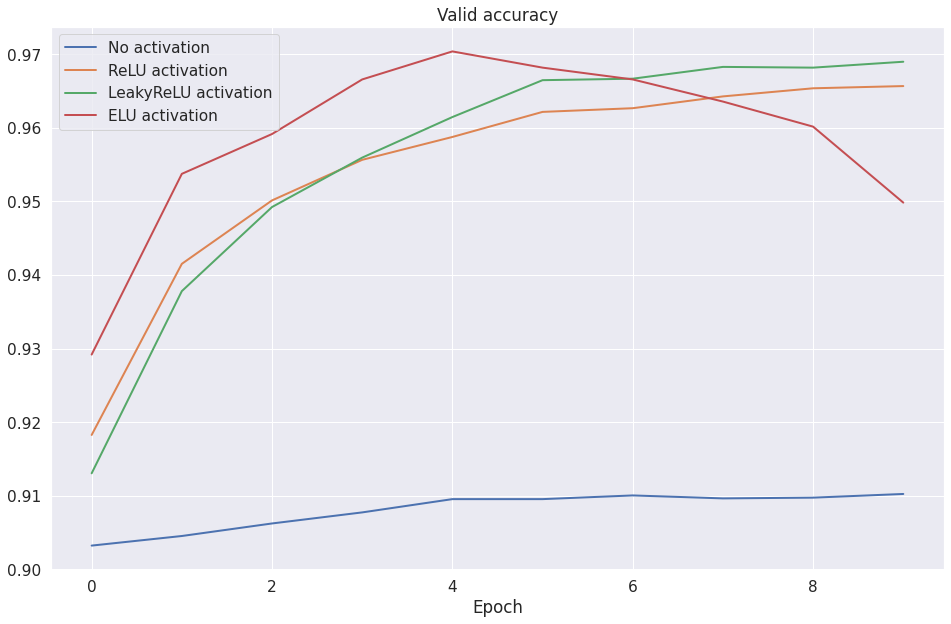

In [55]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

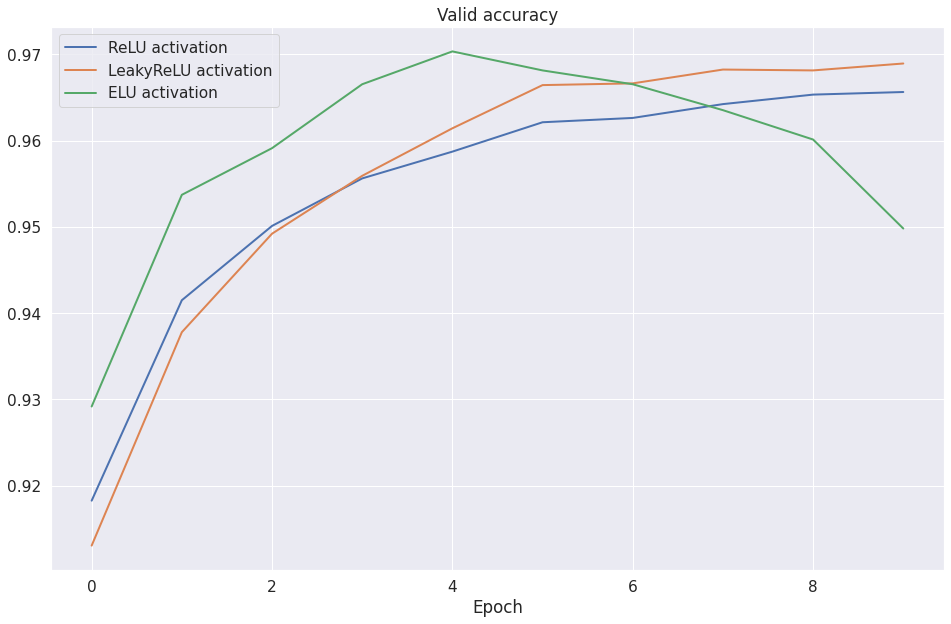

In [56]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** LeakyRelu

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [57]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2022-12-09 16:24:16--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2022-12-09 16:24:16--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 144.76.208.75
Connecting to img.the-village-kz.com (img.the-village-kz.com)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K  --.-KB/s    in 0.02s   

2022-12-09 16:24:16 (1.92 MB/s) - ‘sample_photo.jpg’ saved [49337/

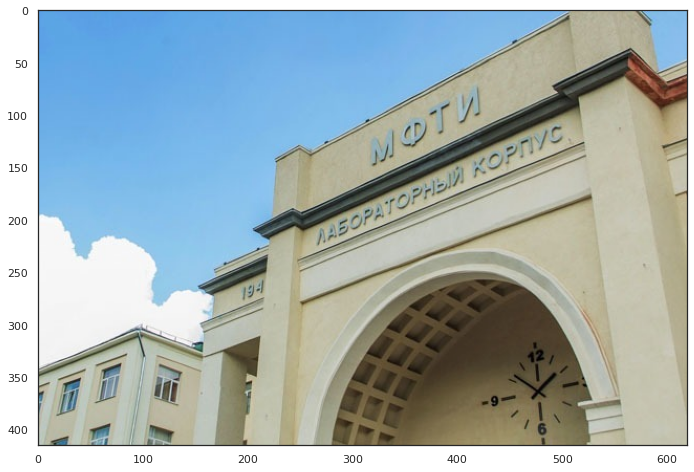

In [58]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

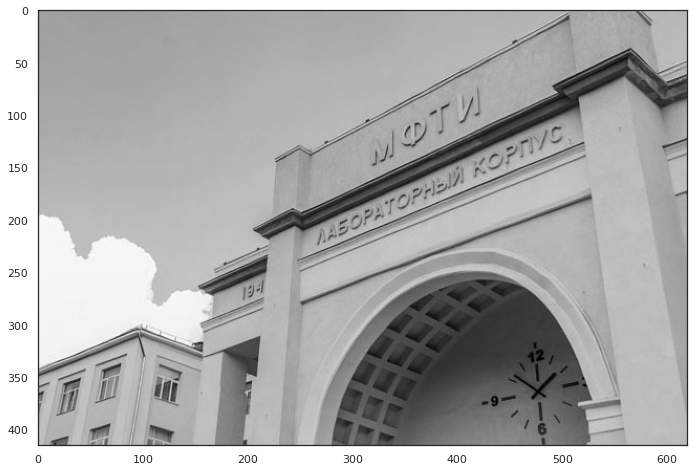

In [59]:
#A)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

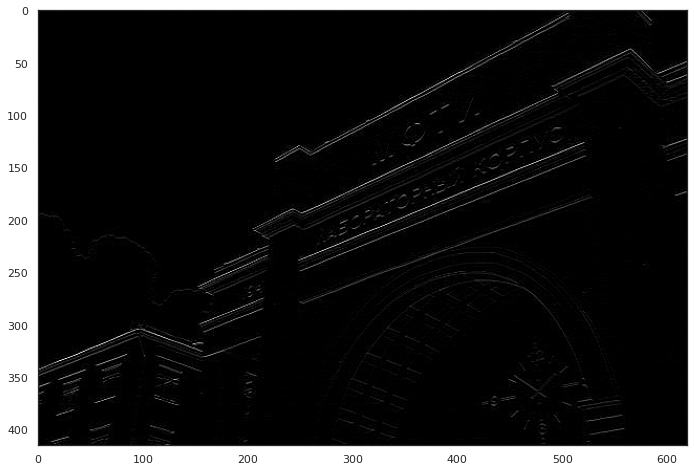

In [60]:
#Б)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [0, -2, 0],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

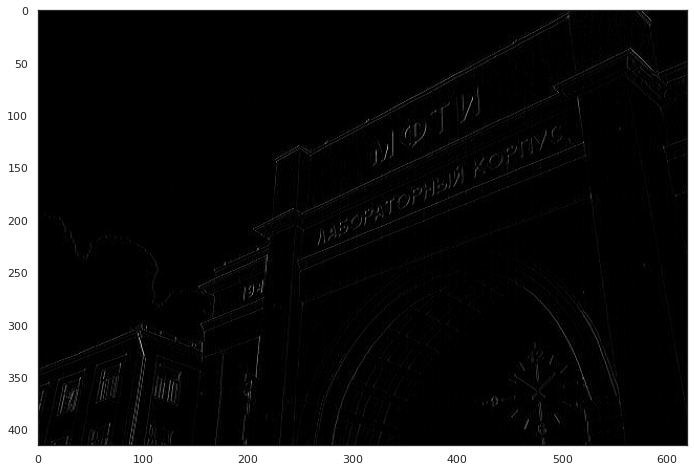

In [61]:
# В)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

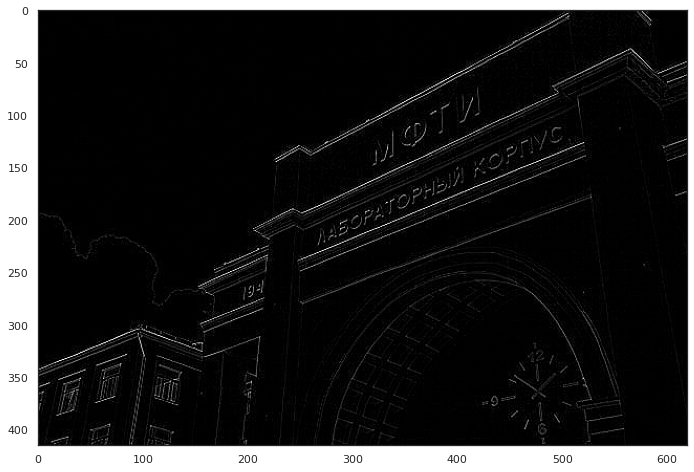

In [62]:
# Г)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

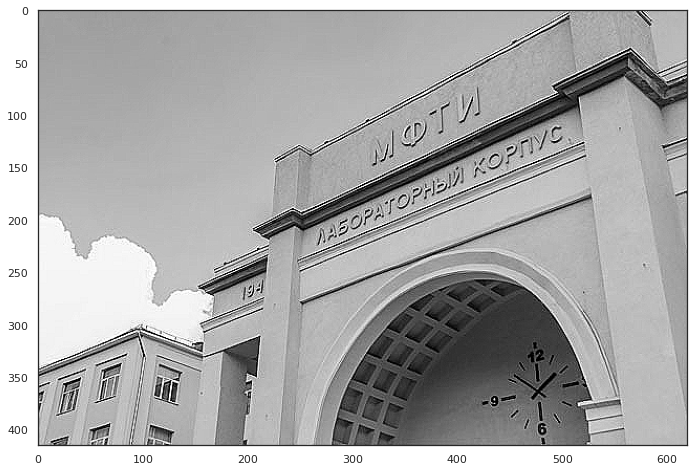

In [63]:
# Д)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

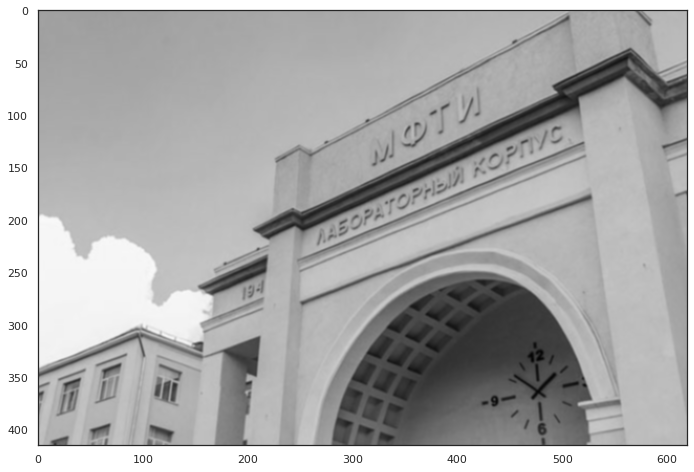

In [64]:
# E)
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
  [0.0625, 0.125, 0.0625],
  [0.125, 0.25, 0.125],
  [0.0625, 0.125, 0.0625]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**

A - 2

Б - 6

В - 2, 6

Г - 6

Д - 2

E -  1

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [70]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3)
        self.pool1 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.conv2 = nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = 3)#YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size=2) #YOUR CODE
        self.fc1 = nn.Linear(16 * 5 * 5, 120)#YOUR CODE
        self.fc2 = nn.Linear(120, 84)#YOUR CODE
        self.fc3 = nn.Linear(84, 10)#YOUR CODE

    def forward(self, x):
        #YOUR CODE. Apply layers created in __init__.
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 16 * 5 * 5)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Проверка размерности входного слоя для полносвязной сети

In [69]:
net = LeNet()
batch = []
batch = next(iter(train_dataloader))
net.forward(torch.FloatTensor(batch[0]))

torch.Size([128, 16, 5, 5])


tensor([[-0.0649, -0.1124,  0.0020,  ..., -0.0698,  0.0292, -0.0883],
        [-0.0632, -0.1237, -0.0075,  ..., -0.0708,  0.0397, -0.0945],
        [-0.0549, -0.1175, -0.0004,  ..., -0.0593,  0.0431, -0.1016],
        ...,
        [-0.0564, -0.1124, -0.0021,  ..., -0.0725,  0.0356, -0.0797],
        [-0.0668, -0.1289, -0.0040,  ..., -0.0631,  0.0274, -0.0839],
        [-0.0559, -0.1331,  0.0028,  ..., -0.0645,  0.0243, -0.0880]],
       grad_fn=<AddmmBackward0>)

как видно torch.Size([128, 16, 5, 5]) значит в полносвязку передаем 16 *5 *5 размерность

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [72]:
# model
model = LeNet().to(device)

# loss
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

# на чем считать
device = "cuda" if torch.cuda.is_available() else "cpu"

# начинаем счиать
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:

            # загружаем батч данных
            # x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!

                #0. перевод в тренировочный режим нашей модели
                model.train()

                # 0.1 Обнуление градиентов
                optimizer.zero_grad()

                # 2. вычисляем скор с помощью прямого распространения
                outp = model(x_batch)
            else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs

                #0. перевод в тестировочный режим нашей модели
                model.eval()

                with torch.no_grad():
                  outp = model(x_batch)

            # индекс макс эл-та есть предикт
            preds = outp.argmax(-1) 

            # сравниваю предикты и лейблы, те что тру = 1 и суммируются - количество правильно предск
            correct = (preds.detach() == y_batch).cpu().numpy().sum() # YOUR CODE GOES HERE

            # кол-во элтов в батче
            all =  preds.shape[0] # YOUR CODE GOES HERE

            # сумма правильных в эпохе
            epoch_correct += correct.item()
            
            # кол-во элтов в эпохе
            epoch_all += all

            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer

                # 3. вычислеяем - функцию потерь (loss)
                loss = criterion(outp, y_batch)

                # history.append(loss.item())

                # 4. вычисляем градиенты
                loss.backward()

                # 5. шаг градиентного спуска
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8684061164529915
Loader: valid. Accuracy: 0.9637419871794872
Epoch: 2
Loader: train. Accuracy: 0.9684995993589743
Loader: valid. Accuracy: 0.9758613782051282
Epoch: 3
Loader: train. Accuracy: 0.9789329594017094
Loader: valid. Accuracy: 0.9813701923076923
Epoch: 4
Loader: train. Accuracy: 0.9840244391025641
Loader: valid. Accuracy: 0.9825721153846154
Epoch: 5
Loader: train. Accuracy: 0.9870626335470085
Loader: valid. Accuracy: 0.9824719551282052
Epoch: 6
Loader: train. Accuracy: 0.9892828525641025
Loader: valid. Accuracy: 0.9826722756410257
Epoch: 7
Loader: train. Accuracy: 0.9911525106837606
Loader: valid. Accuracy: 0.9815705128205128
Epoch: 8
Loader: train. Accuracy: 0.9922041933760684
Loader: valid. Accuracy: 0.9822716346153846
Epoch: 9
Loader: train. Accuracy: 0.9937065972222222
Loader: valid. Accuracy: 0.9808693910256411
Epoch: 10
Loader: train. Accuracy: 0.9938568376068376
Loader: valid. Accuracy: 0.9832732371794872


In [73]:
lenet_accuracy = accuracy["valid"]
lenet_accuracy

[0.9637419871794872,
 0.9758613782051282,
 0.9813701923076923,
 0.9825721153846154,
 0.9824719551282052,
 0.9826722756410257,
 0.9815705128205128,
 0.9822716346153846,
 0.9808693910256411,
 0.9832732371794872]

Сравним с предыдущем пунктом

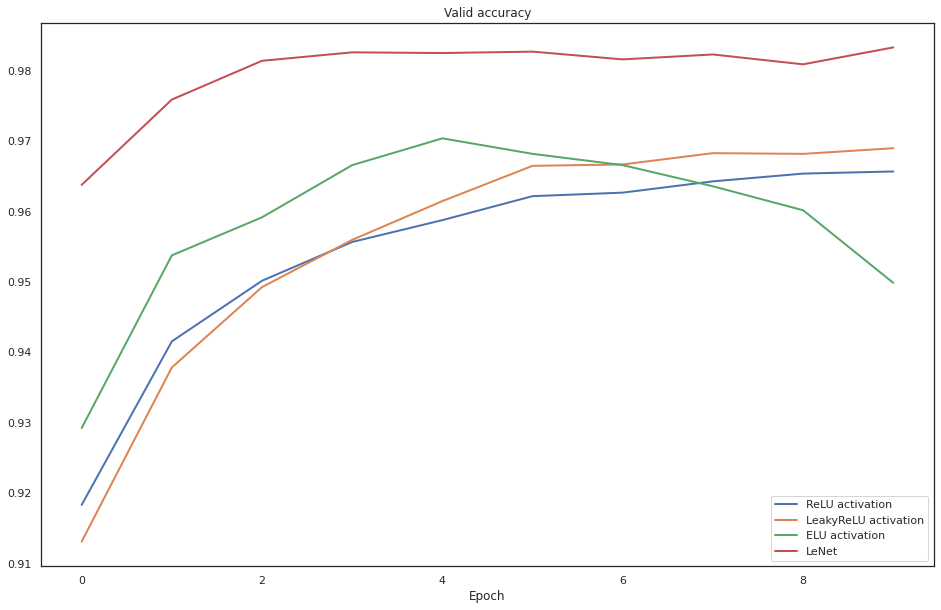

In [74]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

In [75]:
max(lenet_accuracy)

0.9832732371794872

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0,98